# Criando datasets

## Desenvolvimento

### Carregando as bibliotecas

In [1]:
#collapse-hide
# === Some imports and setup === #

# Setup Detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Common libraries
import numpy as np
import os, json, cv2, random

# Detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

### Lendo e redimensionando imagem

In [2]:
#im = cv2.imread("0004_c1s6_016996_00.jpg")
#im = cv2.imread("1047_c1s4_074261_00.jpg")
#im = cv2.imread("0016_c6s1_011151_00.jpg")
#im = cv2.imread("0021_c5s1_002176_00.jpg")

im = cv2.imread("0001_c6s1_009601_00.jpg")

height, width = im.shape[:2]

im = cv2.resize(im, (int(2*width), int(4*height)), interpolation = cv2.INTER_CUBIC)

In [3]:
#collapse-hide
# === Look at the image, in array form === #
print("Image dimensions:", im.shape)
print("\nImage array - first row of 3-value sub-arrays:")

Image dimensions: (512, 128, 3)

Image array - first row of 3-value sub-arrays:


### Carregando modelo de segmentacao

In [4]:
# === Set up config and run inference === #

# Add project-specific config (e.g., TensorMask) here if you're
# not running a model in Detectron2's core library
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

### Valor baixo de thershold, varias deteccoes e escolhe-se a de maior area. O processo esta implementado abaixo. Note que essa abordagem e coerente, porque o pedestre esta em evidencia na imagem

In [5]:
#outputs["instances"].pred_classes.cpu()
#predictor.metadata.as_dict()["thing_classes"][13]

area_list = []

for i in outputs["instances"].pred_boxes:
    area_list.append((i[2] - i[0])*(i[3] - i[1]))
    
print(area_list)
print(area_list.index(max(area_list)))

print(outputs["instances"].pred_classes.cpu())
int(outputs["instances"].pred_classes.cpu()[area_list.index(max(area_list))])

[tensor(45707.0625, device='cuda:0'), tensor(51702.2695, device='cuda:0'), tensor(25345.0273, device='cuda:0'), tensor(38457.5078, device='cuda:0')]
1
tensor([ 0, 17, 17,  0])


17

### Visualizando as segmentacoes

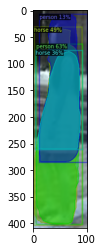

In [7]:
# `Visualizer` draws the predictions on the image
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [8]:
class_ids = np.array(outputs["instances"].pred_classes.cpu())
np.where(class_ids == 0)

(array([0, 3]),)

In [9]:
# === Extract (only) the mask and box of Hobbes === #
# Find the index of the class we are interested in
# First, convert to numpy array to allow direct indexing
class_ids = np.array(outputs["instances"].pred_classes.cpu())
class_index = np.where(class_ids == 0)  # Find index where class ID is 16
# Use that index to index the array of masks and boxes
#mask_tensor = outputs["instances"].pred_masks[class_index]

mask_tensor = outputs["instances"].pred_masks[np.array([area_list.index(max(area_list))])]

print(mask_tensor.shape)
mask_tensor

torch.Size([1, 512, 128])


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [10]:
# Convert tensor to numpy array
hobbes_mask = mask_tensor.cpu()
print("Before:", type(hobbes_mask))
print(hobbes_mask.shape)
hobbes_mask = np.array(hobbes_mask[0])
print("After:", type(hobbes_mask))
print(hobbes_mask.shape)

Before: <class 'torch.Tensor'>
torch.Size([1, 512, 128])
After: <class 'numpy.ndarray'>
(512, 128)


In [11]:
# Create blank black background
# The "True" pixels will be converted to white and copied onto the black background
background = np.zeros(hobbes_mask.shape)
background.shape

(512, 128)

In [12]:
# Add white pixels where mask values are True
bin_mask = np.where(hobbes_mask, 255, background).astype(np.uint8)
print(bin_mask.shape)
bin_mask

(512, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Visualizando a mascara

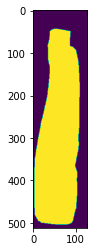

In [14]:
# Show the resulting binary mask
plt.imshow(bin_mask)

In [15]:
# === Add a fourth channel to the original image array === #

# Split into RGB (technically BGR in OpenCV) channels
b, g, r = cv2.split(im.astype("uint8"))

# Create alpha channel array of ones
# Then multiply by 255 to get the max transparency value
a = np.ones(hobbes_mask.shape, dtype="uint8") * 255

print(b.shape, g.shape, r.shape, a.shape)

(512, 128) (512, 128) (512, 128) (512, 128)


(512, 128, 4)


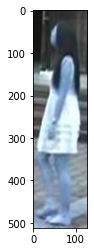

In [16]:
# === Merge image channels back together === #

# Rejoin with alpha channel that's always 1, or non-transparent
rgba = [b, g, r, a]
# Both of the lines below accomplish the same thing
im_4ch = cv2.merge(rgba, 4)


# im_4ch = np.stack([b, g, r, a], axis=2)

print(im_4ch.shape)
plt.imshow(im_4ch)

### Resultado apos a segmentacao

BG shape: (512, 128, 4)
Mask shape: (512, 128, 4)


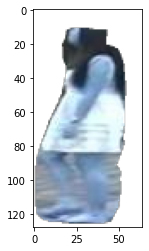

In [17]:
# === Extract pixels using mask === #

# Create 4-channel blank background
bg = np.zeros(im_4ch.shape)
print("BG shape:", bg.shape)

# Create 4-channel mask
mask = np.stack([hobbes_mask, hobbes_mask, hobbes_mask, hobbes_mask], axis=2)
print("Mask shape:", mask.shape)

# Copy color pixels from the original color image where mask is set
foreground = np.where(mask, im_4ch, bg).astype(np.uint8)

height, width = foreground.shape[:2]

foreground = cv2.resize(foreground, (int(width/2), int(height/4)), interpolation = cv2.INTER_CUBIC)

# Check out the result
plt.imshow(foreground)

In [76]:
cv2.imwrite('test.jpg',foreground)

True

# Criando novo dataset para o Market-1501

In [38]:
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

### Escolha o tipo de dado (query, bounding_box_test ou bounding_box_train) e atribua a variavel dataset. No processo abaixo as imagens sao lidas do dataset original e escritas no novo dataset, por conta disso, defina os paths corretamente. 

imagem vazia
/home/dwfs2/Desktop/remove_background/Market-1501/query/Thumbs.db


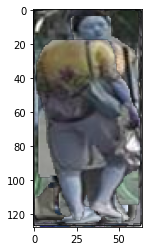

In [39]:
dataset = 'query'

for i in os.listdir('/home/dwfs2/Desktop/remove_background/Market-1501/'+dataset):
    
    try:
    
        img = cv2.imread('/home/dwfs2/Desktop/remove_background/Market-1501/'+dataset+'/'+i)
        
        height, width = img.shape[:2]

        img = cv2.resize(img, (int(2*width), int(3*height)), interpolation = cv2.INTER_CUBIC)

        outputs = predictor(img)
        
        area_list = []

        for k in outputs["instances"].pred_boxes:
            area_list.append((k[2] - k[0])*(k[3] - k[1]))
    
        #print(area_list)
        #print(area_list.index(max(area_list)))

        #print(outputs["instances"].pred_classes.cpu())
        #int(outputs["instances"].pred_classes.cpu()[area_list.index(max(area_list))])
        
        id_max = int(outputs["instances"].pred_classes.cpu()[area_list.index(max(area_list))])

        class_ids = np.array(outputs["instances"].pred_classes.cpu())
        class_index = np.where(class_ids == id_max)  # Find index where class ID is 16
        # Use that index to index the array of masks and boxes
        #mask_tensor = outputs["instances"].pred_masks[class_index]
        mask_tensor = outputs["instances"].pred_masks[np.array([area_list.index(max(area_list))])]

        # Convert tensor to numpy array
        mask = mask_tensor.cpu()
        mask = np.array(mask[0])

        # Create blank black background
        # The "True" pixels will be converted to white and copied onto the black background
        background = np.zeros(mask.shape)

        # Add white pixels where mask values are True
        bin_mask = np.where(mask, 255, background).astype(np.uint8)

        # Split into RGB (technically BGR in OpenCV) channels
        b, g, r = cv2.split(img.astype("uint8"))

        # Rejoin with alpha channel that's always 1, or non-transparent
        rgba = [b, g, r, a]
        # Both of the lines below accomplish the same thing
        im_4ch = cv2.merge(rgba, 4)

        # === Extract pixels using mask === #

        # Create 4-channel blank background
        bg = np.zeros(im_4ch.shape)

        # Create 4-channel mask
        mask_final = np.stack([mask, mask, mask, mask], axis=2)

        # Copy color pixels from the original color image where mask is set
        foreground = np.where(mask_final, im_4ch, bg).astype(np.uint8)
        
        height, width = foreground.shape[:2]

        foreground = cv2.resize(foreground, (int(width/2), int(height/3)), interpolation = cv2.INTER_CUBIC)

        # Check out the result
        plt.imshow(foreground)
        
        cv2.imwrite('/home/dwfs2/Desktop/remove_background/output_Market-1501/'+dataset+'/'+i,foreground)
        
    except:
          
        try:
            
            height, width = img.shape[:2]
            
            img = cv2.resize(img, (int(width/2), int(height/3)), interpolation = cv2.INTER_CUBIC)
            
            cv2.imwrite('/home/dwfs2/Desktop/remove_background/output_Market-1501/'+dataset+'_error'+'/'+i,img)
    
        except:
            
            print("imagem vazia")
            print('/home/dwfs2/Desktop/remove_background/Market-1501/'+dataset+'/'+i)